### koppla databas & server

In [13]:
import pandas as pd
from neo4j import GraphDatabase
from graphdatascience import GraphDataScience
import seaborn as sns
import matplotlib.pyplot as plt




In [14]:
graph_db =  GraphDatabase.driver(uri = "bolt://localhost:7687", auth=("neo4j", "password"))

In [15]:
URI  = "bolt://localhost:7687"
creds=("neo4j", "password")

gds =  GraphDataScience(URI,auth=(creds ))


### Skapar project

In [17]:
result = gds.run_cypher(
  """
 CALL gds.graph.project(
    'myGraph_1',
    '*',
    '*',
    {
        relationshipProperties: 'distance'
    }
)
  """
)
display(result)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'__ALL__': {'label': '*', 'properties': {}}}","{'__ALL__': {'orientation': 'NATURAL', 'aggreg...",myGraph_1,61,100,8


### ta bort om den finns

In [16]:
result = gds.run_cypher(
  """
    CALL gds.graph.drop('myGraph')
  """
)
display(result)

,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,myGraph,neo4j,,-1,61,100,{'relationshipProjection': {'__ALL__': {'orien...,0.027322,2022-11-10T15:54:14.116785200+01:00,2022-11-10T15:54:14.121797100+01:00,"{'graphProperties': {}, 'relationships': {'__A..."


### lista vilka project som är skapade

In [18]:

result = gds.run_cypher(
  """
    CALL gds.graph.list()
  """
)
display(result)

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,"{'p99': 6, 'min': 0, 'max': 9, 'mean': 1.63934...",myGraph_1,neo4j,2348 KiB,2404472,61,100,{},0.027322,2022-11-11T08:43:32.303128800+01:00,2022-11-11T08:43:32.309131800+01:00,"{'graphProperties': {}, 'relationships': {'__A..."


##### Först och främst kommer vi att uppskatta kostnaden för att köra algoritmen med hjälp av estimateproceduren. Detta kan göras med vilket exekveringsläge som helst. Vi kommer att använda writeläget i detta exempel. Att uppskatta algoritmen är användbart för att förstå den minneseffekt som körning av algoritmen på din graf kommer att ha. När du senare faktiskt kör algoritmen i ett av exekveringslägena kommer systemet att utföra en uppskattning. Om uppskattningen visar att det finns en mycket hög sannolikhet att exekveringen överskrider sina minnesbegränsningar, är exekveringen förbjuden

In [103]:
result = gds.run_cypher(
  """
MATCH (source:Aggregat {name: 'Airaggregat'}), (target:Sensor {name: 'sensor_5'})

CALL gds.shortestPath.dijkstra.write.estimate('myGraph_1', {
    sourceNode: source,
    targetNode: target,
    relationshipWeightProperty: 'distance',
    writeRelationshipType: 'PATH'
})
YIELD nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
RETURN nodeCount, relationshipCount, bytesMin, bytesMax, requiredMemory
  """
)
display(result)



,nodeCount,relationshipCount,bytesMin,bytesMax,requiredMemory
0,61,100,2672,2672,2672 Bytes


##### I streamexekveringsläget returnerar algoritmen den kortaste vägen för varje käll-mål/node. Detta gör att vi kan inspektera resultaten direkt eller efterbehandla dem i Cypher utan några biverkningar. Resultatet visar den totala kostnaden för den kortaste vägen mellan nod Aggregat och nod Sensor. Den visar också en ordnad lista över nod-id som korsades för att hitta den kortaste vägen samt de ackumulerade kostnaderna för de besökta noderna

,index,sourceNodeName,targetNodeName,totalCost,nodeNames,distance,path
0,0,Airaggregat,sensor_4,29.1,"[Airaggregat, From_air, Tilluft_hub1, Tilluft_...","[0.0, 0.0, 10.5, 15.5, 18.5, 20.0, 28.1, 29.1]","[(name, To_air, From_air), (name, class), (nam..."


Airaggregat ---Från källnod till målnod-----> From_air ---Från källnod till målnod-----> Tilluft_hub1 ---Från källnod till målnod-----> Tilluft_hub2 ---Från källnod till målnod-----> Tilluft_hub3 ---Från källnod till målnod-----> Tilluft_hub4 ---Från källnod till målnod-----> T104 ---Från källnod till målnod-----> sensor_4
Totalt antal noder 8


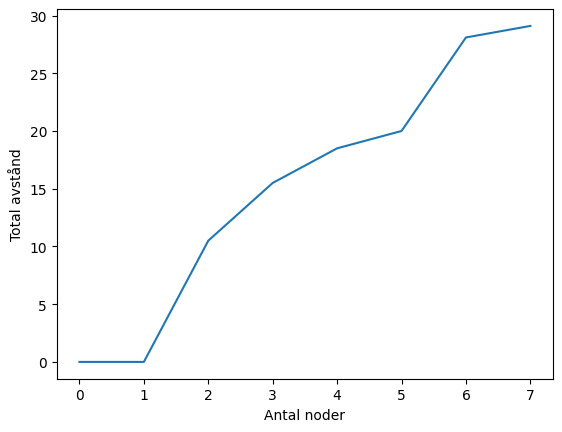

In [114]:
result = gds.run_cypher(
 """
MATCH (source:Aggregat {name: 'Airaggregat'}), (target:Sensor {name: 'sensor_4'})
CALL gds.shortestPath.dijkstra.stream('myGraph_1', {
    sourceNode: source,
    targetNode: target,
    relationshipWeightProperty: 'distance'
})
YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
RETURN
    index,
    gds.util.asNode(sourceNode).name AS sourceNodeName,
    gds.util.asNode(targetNode).name AS targetNodeName,
    totalCost,
    [nodeId IN nodeIds | gds.util.asNode(nodeId).name] AS nodeNames,
    costs as distance,
    nodes(path) as path
ORDER BY index
"""
)
display(result)

node=result['nodeNames']
distance = result['distance']
path = result['path']


for x in node:
  print(*x,sep=' ---Från källnod till målnod-----> ')

print(f'Totalt antal noder {len(node[0])}')



  
for x in distance:
  plt.plot(x)
  plt.ylabel('Total avstånd')
  plt.xlabel('Antal noder')
  plt.show()




In [115]:


result = gds.run_cypher(
 """
CALL gds.nodeSimilarity.stats('myGraph_1')
YIELD nodesCompared, similarityPairs

"""
)
display(result)

,nodesCompared,similarityPairs
0,48,135


### Node_similarty
#### Likhetsalgoritmer beräknar likheten mellan par av noder baserat på deras grannskap eller egenskaper. Algoritmen Node Similarity jämför en uppsättning noder baserat på noderna de är anslutna till. Två noder anses vara lika om de delar många av samma grannar.



In [23]:
result = gds.run_cypher(
  """
CALL gds.graph.project('myGraph','*','*')
  """
)
display(result)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'__ALL__': {'label': '*', 'properties': {}}}","{'__ALL__': {'orientation': 'NATURAL', 'aggreg...",myGraph,61,100,7


In [24]:
result = gds.run_cypher(
  """
    CALL gds.graph.list()
  """
)
display(result)

,degreeDistribution,graphName,database,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema
0,"{'p99': 6, 'min': 0, 'max': 9, 'mean': 1.63934...",myGraph,neo4j,298 KiB,305736,61,100,{'relationshipProjection': {'__ALL__': {'orien...,0.027322,2022-11-11T08:51:15.843296200+01:00,2022-11-11T08:51:15.850261600+01:00,"{'graphProperties': {}, 'relationships': {'__A..."
1,"{'p99': 6, 'min': 0, 'max': 9, 'mean': 1.63934...",myGraph_1,neo4j,2363 KiB,2419800,61,100,{},0.027322,2022-11-11T08:43:32.303128800+01:00,2022-11-11T08:43:32.309131800+01:00,"{'graphProperties': {}, 'relationships': {'__A..."


In [101]:
result = gds.run_cypher(
  """
CALL gds.nodeSimilarity.stream('myGraph')
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).name AS Jämför_node_1, gds.util.asNode(node2).name AS jämför_node_2, similarity
ORDER BY similarity DESCENDING, Jämför_node_1, jämför_node_2
  """
)

result

,Jämför_node_1,jämför_node_2,similarity
0,F101,F103,1.000000
1,F102,Frånluft_hub2,1.000000
2,F103,F101,1.000000
3,Frånluft_hub2,F102,1.000000
4,Matsal,Tilluft_hub9,1.000000
...,...,...,...
130,T109,Kontor,0.111111
131,T114,Kontor,0.111111
132,T115,Kontor,0.111111
133,Zon1,Zon2,0.111111


Text(13.819444444444459, 0.5, 'Antal Noder')

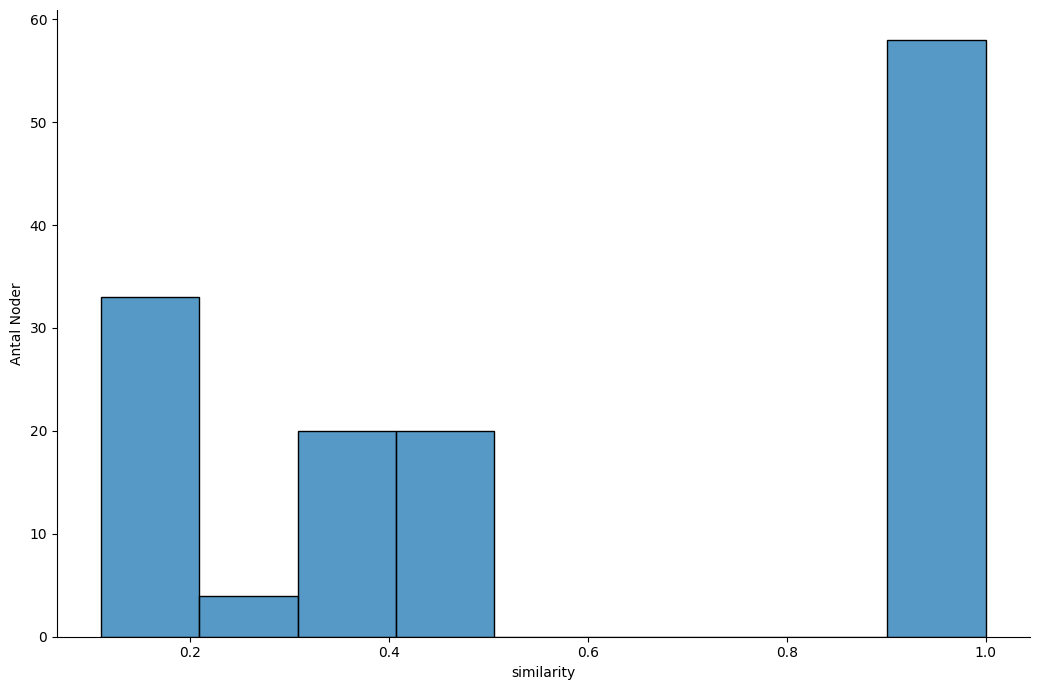

In [102]:
sns.displot(data=result, x="similarity", height=7, aspect=1.5)
plt.ylabel("Antal Noder")

### PageRank
#### PageRank-algoritmen mäter vikten av varje nod i grafen, baserat på antalet inkommande relationer och vikten av motsvarande källnoder. Det underliggande antagandet är grovt sett att en node bara är lika viktig som de noder som länkar till den.

In [31]:
result = gds.run_cypher(
  """
CALL gds.graph.project('myGraph_2','*','*')
  """
)
display(result)

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'__ALL__': {'label': '*', 'properties': {}}}","{'__ALL__': {'orientation': 'NATURAL', 'aggreg...",myGraph_2,61,100,6


In [74]:
result = gds.run_cypher(
  """
CALL gds.pageRank.stream('myGraph_2')
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS name, score
ORDER BY score DESC, name ASC
  """
)

df =result.head(10)

Text(0.5, 7.350694444444445, 'De första 10 viktiga noder')

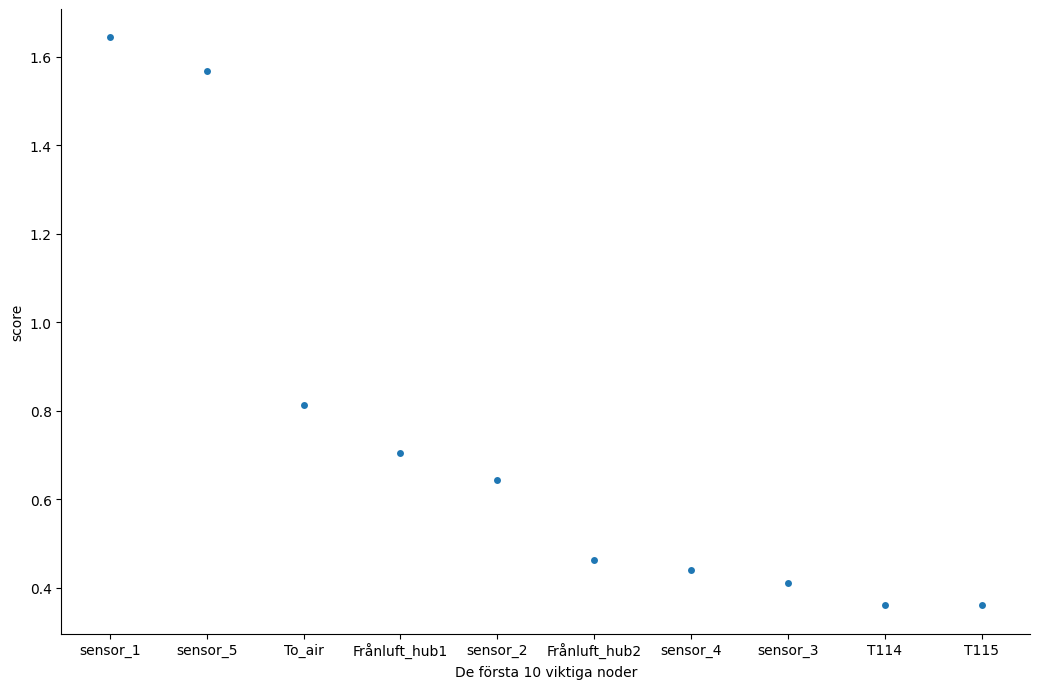

In [99]:
sns.catplot(data=df, x="name",y="score" ,height=7, aspect=1.5)
plt.xlabel("De första 10 viktiga noder")

In [149]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1380 entries, 0 to 1379
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   n       1380 non-null   object
 1   t       1380 non-null   object
 2   s       1380 non-null   object
 3   a       1380 non-null   object
dtypes: object(4)
memory usage: 43.2+ KB
